In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import uqer
import numpy as np
import pandas as pd
from uqer import DataAPI as api
import alphamind.data.store as store
from alphamind.data.store import append_industry_info
from alphamind.data.neutralize import neutralize

plt.style.use('ggplot')

当前 SDK 版本号是: 1.2.6 已是最新版


In [2]:
_ = uqer.Client(token='f1b9bea1d0b4e489c5ab9b69c3e2326a1bee6057af858067dbd1546453f428b2')

使用token: f1b9bea1d0b4e489c5ab9b69c3e2326a1bee6057af858067dbd1546453f428b2 验证成功


In [3]:
ref_date = '20170623'
factor = 'FY12P'
weight_factor = 'LFLO'

# Algorithm Description
--------------------------

猜测的 ``neutralize`` 残差$\bar Res$计算公式：

$$\bar Res_{i,k} = \bar f_{i,k} - \sum_j \beta_{j,k} \times \bar Ex_{i, j, k}$$

其中：$k$为行业分类，$i$为该行业中第$i$只股票，$j$为第$j$个风险因子。$\bar f$为因子序列，$\bar Ex$为风险暴露矩阵。系数$\beta_{j,k}$由OLS确定。

下面的章节，我们分别比较三种``neutralize``的方法差别：

* **UQER Neutralize**

    使用优矿的SDK计算因子残差。


* **Alpha-Mind Neutralize**

    使用alpha-mind计算因子残差，alpha-mind可以由以下地址安装：
    
    ```
    https://github.com/wegamekinglc/alpha-mind
    ```

* **Direct Weighted Least Square Fit Implementation**

    直接使用scikit-learn的线性回归功能来计算因子残差。


# Raw Data
---------------------------

In [4]:
risk_factors = pd.read_pickle('20170623.csv')

In [5]:
risk_styles = risk_factors.columns[1:].tolist()

In [6]:
factor_data = api.MktStockFactorsOneDayGet(tradeDate=ref_date, field='ticker,' + factor + ',' + weight_factor)
total_data = pd.merge(factor_data, risk_factors, on=['ticker'])
total_data.set_index('ticker', inplace=True)
total_data.dropna(inplace=True)

In [7]:
total_data.head()

,FY12P,LFLO,BETA,MOMENTUM,SIZE,EARNYILD,RESVOL,GROWTH,BTOP,LEVERAGE,...,BEV,FOODPROD,HEALTH,BANKS,DVFININS,REALEST,SOFTWARE,HDWRSEMI,UTILITIE,COUNTRY
ticker,,,,,,,,,,,,,,,,,,,,,
600778,-0.0916,21.6110,1.678,-1.031,-2.916,-3.419,-0.922,-1.468,0.224,1.801,...,0,0,0,0,0,0,0,0,0,1
000962,-0.0819,22.0732,0.616,-1.163,-2.363,-2.523,0.616,-2.122,-0.255,-0.426,...,0,0,0,0,0,0,0,0,0,1
601608,-0.0345,23.8892,0.265,-0.277,-0.170,-2.712,-1.117,-1.617,-0.764,0.310,...,0,0,0,0,0,0,0,0,0,1
600096,-0.0059,22.8140,1.105,-1.336,-1.280,-2.718,-1.250,-0.935,-0.186,2.400,...,0,0,0,0,0,0,0,0,0,1
002154,-0.0046,22.1009,1.179,-2.021,-2.144,-2.722,-1.028,-0.841,0.588,-0.419,...,0,0,0,0,0,0,0,0,0,1


In [8]:
len(total_data)

2406

In [9]:
total_data['FLO'] = np.exp(total_data['LFLO'])
total_data['wls'] = (total_data['FLO'] / total_data['FLO'].sum()) ** 2

# UQER Neutralize
-----------------------

In [11]:
%%time
neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date,
                                          risk_module='short',
                                          industry_type='short')

Wall time: 169 ms


In [12]:
df = pd.DataFrame(neutralized_factor_uqer, columns=['uqer'])
df.head()

,uqer
000001,0.015150
000002,-0.003985
000006,-0.008520
000008,0.003012
000010,0.020408


In [13]:
len(neutralized_factor_uqer)

2406

# Alpha-Mind Neutralize
--------------------------

In [14]:
x = total_data[risk_styles].values
y = total_data[factor].values

In [17]:
%%time
neutralized_factor_alphamind = neutralize(x, y, weights=np.ones(len(y)))

Wall time: 1 ms


In [18]:
alphamind_series = pd.Series(neutralized_factor_alphamind.flatten(), index=total_data.index)
df['alpha-mind'] = alphamind_series

In [19]:
len(alphamind_series)

2406

# The Ticker Missing in UQER but Still in Alpha-Mind
-----------------------------------

In [20]:
missed_codes = [c for c in alphamind_series.index if c not in neutralized_factor_uqer.index]

In [21]:
total_data.ix[missed_codes]

,FY12P,LFLO,BETA,MOMENTUM,SIZE,EARNYILD,RESVOL,GROWTH,BTOP,LEVERAGE,...,HEALTH,BANKS,DVFININS,REALEST,SOFTWARE,HDWRSEMI,UTILITIE,COUNTRY,FLO,wls
ticker,,,,,,,,,,,,,,,,,,,,,


# Direct Weighted Least Square Fit Implementation
------------------------

In [22]:
import statsmodels.api as sm

In [23]:
mod = sm.WLS(y, x, weights=np.ones(len(y))).fit()
lg_series = pd.Series(mod.resid, index=total_data.index)

In [24]:
mod.resid

array([-0.07230463, -0.0828871 , -0.03309311, ...,  0.04199391,
        0.09846184,  0.47469864])

In [25]:
df['ols'] = lg_series

# Comparison
------------------

In [30]:
df['uqer - ols'] = df['uqer'] - df['ols']
df['alphamind - ols'] = df['alpha-mind'] - df['ols']

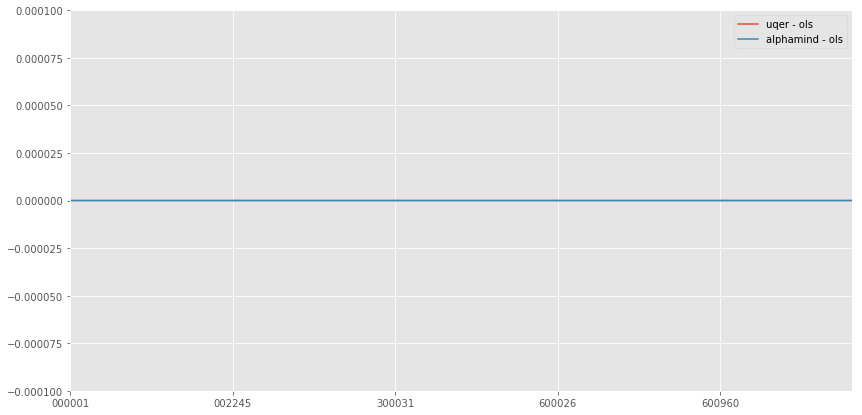

In [31]:
df[['uqer - ols', 'alphamind - ols']].plot(figsize=(14, 7), ylim=(-1e-4, 1e-4))

In [32]:
df.head()

,uqer,alpha-mind,ols,uqer - ols,alphamind - ols
000001,0.015150,0.015150,0.015150,2.775558e-17,3.053113e-16
000002,-0.003985,-0.003985,-0.003985,1.942890e-16,1.110223e-16
000006,-0.008520,-0.008520,-0.008520,-2.636780e-16,-4.163336e-17
000008,0.003012,0.003012,0.003012,-1.595946e-16,-1.700029e-16
000010,0.020408,0.020408,0.020408,-6.383782e-16,-2.914335e-16


# Missing Codes for UQER neutralize in 2017
--------------------------------

In [23]:
from PyFin.api import bizDatesList

In [24]:
biz_dates = bizDatesList('china.sse', '2017-01-05', '2017-07-03')

In [25]:
missed_codes_dict = {}

for date in biz_dates:
    ref_date = date.strftime('%Y%m%d')
    factor_data = api.MktStockFactorsOneDayGet(tradeDate=ref_date, field='ticker,' + factor)
    risk_factors = api.RMExposureDayGet(tradeDate=ref_date)
    append_industry_info(risk_factors)

    total_data = pd.merge(factor_data, risk_factors, on=['ticker'])
    total_data.set_index('ticker', inplace=True)
    total_data.dropna(inplace=True)
    
    neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                              target_date=ref_date,
                                              risk_module='day',
                                              industry_type='day')
    
    missed_codes = [c for c in total_data.index if c not in neutralized_factor_uqer.index]
    missed_codes_dict[date] = missed_codes

In [26]:
missing_codes = pd.Series(missed_codes_dict)
missing_codes.head()

2017-01-05    [002821]
2017-01-06    [002821]
2017-01-09    [002821]
2017-01-10    [002821]
2017-01-11    [002821]
dtype: object